# Data

### Source: https://www.kaggle.com/currie32/crimes-in-chicago/data
Crimes in Chicago from 2001 to 2017 (1.85GB)

This data is broken up into 4 files:<br>
Chicago_Crimes_2001_to_2004.csv<br>
Chicago_Crimes_2005_to_2007.csv<br>
Chicago_Crimes_2008_to_2011.csv<br>
Chicago_Crimes_2012_to_2017.csv<br>



In [20]:
from pyspark.sql import functions as func
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas


FILE_PATH = "hdfs://sandbox.hortonworks.com:8020/bigdata1_final_project/Chicago_Crimes_*.csv"

crime_df = sqlContext.read.load(FILE_PATH,
                        format='com.databricks.spark.csv',
                        header='true',
                        inferSchema=True)
print("Loaded DataFrame")

# Columns and data types

print("Columns:")
for f in crime_df.schema.fields:
    print("%s (%s)" % (f.name, f.dataType))
print('+--------------------------------+')

crime_df.select("Primary Type").distinct().sort("Primary Type").show(200, False)

print("Cleaning Primary Type")
def clean_primary_types(val):
    if val in ("NON - CRIMINAL", "NON-CRIMINAL", "NON-CRIMINAL (SUBJECT SPECIFIED)"):
        return "NON-CRIMINAL"
    if "NARCOTIC" in val:
        return "NARCOTICS"
    return val

clean_primary_types_udf = func.udf(clean_primary_types, StringType())

crime_df = crime_df.withColumn("Primary Type", clean_primary_types_udf(crime_df["Primary Type"]))

crime_df.select("Primary Type").distinct().sort("Primary Type").show(200, False)

# TODO: convert Date into Date Type

Loaded DataFrame
Columns:
_c0 (IntegerType)
ID (IntegerType)
Case Number (StringType)
Date (StringType)
Block (StringType)
IUCR (StringType)
Primary Type (StringType)
Description (StringType)
Location Description (StringType)
Arrest (StringType)
Domestic (StringType)
Beat (StringType)
District (StringType)
Ward (StringType)
Community Area (StringType)
FBI Code (StringType)
X Coordinate (StringType)
Y Coordinate (StringType)
Year (StringType)
Updated On (StringType)
Latitude (StringType)
Longitude (StringType)
Location (StringType)
+--------------------------------+
+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE             

### Clean up Year Column

There were some bad columns that did not contain valid years.
I also chose to remove data for 2017 as it was incomplete and ended up being outliner in all of the analysis.


In [21]:
crime_df.select("Year").distinct().show()

# clean
valid_years = list(range(2001, 2017))  # 2001 to 2016
crime_df = crime_df.filter(crime_df.Year.isin(valid_years))
print("Done cleaning year data...")

+------------+
|        Year|
+------------+
|        2016|
|        2012|
|Y Coordinate|
|        2017|
|        2014|
|        2013|
|        2005|
|        2002|
|        2009|
|        2006|
|        2004|
|        2011|
|        2008|
|        2007|
|41.789832136|
|        2015|
|        2001|
|        2010|
|        2003|
+------------+

Done cleaning year data...


# Location Analysis

## Unique Crime Location Descriptions
After grouping crime by location descriptions, I selected records with a count of one.
These are the ones I defined as "unique locations".

In [22]:
# Group by location descriptions
location_all_counts_df = crime_df.groupBy("Location Description").count()
# Filter to locations that only appear once
single_occurance_crime_df = location_all_counts_df.filter("count == 1")
# Use flat map to get a simple list
locations = single_occurance_crime_df.select("Location Description").rdd.flatMap(lambda x:x).collect()
# Rename column to remove space, to get it working with isin() method and filter to get only uniq locations
col_renamed_df = crime_df.withColumnRenamed("Location Description", "LocationDescription")
filtered_df = col_renamed_df.filter(col_renamed_df.LocationDescription.isin(locations))

print("*** Most Unique Crime Locations ***")
filtered_df.select(
    "LocationDescription", "Primary Type", "Date", "Case Number").show(50, False)


*** Most Unique Crime Locations ***
+----------------------+------------+----------------------+-----------+
|LocationDescription   |Primary Type|Date                  |Case Number|
+----------------------+------------+----------------------+-----------+
|PUBLIC GRAMMAR SCHOOL |HOMICIDE    |07/09/2002 11:55:00 PM|HH499180   |
|JUNK YARD/GARBAGE DUMP|HOMICIDE    |08/01/2002 04:15:00 AM|HH549811   |
|FUNERAL PARLOR        |HOMICIDE    |11/13/2002 07:25:00 PM|HH777608   |
|TRUCKING TERMINAL     |HOMICIDE    |08/14/2003 09:10:00 AM|HJ561015   |
|LIVERY AUTO           |HOMICIDE    |10/05/2006 04:50:00 AM|HM641124   |
|BANQUET HALL          |HOMICIDE    |09/23/2007 01:23:00 AM|HN605728   |
|ROOMING HOUSE         |HOMICIDE    |01/24/2009 02:26:00 AM|HR136031   |
|ELEVATOR              |HOMICIDE    |01/29/2016 06:43:00 PM|HZ126483   |
|CLEANERS/LAUNDROMAT   |HOMICIDE    |03/02/2016 02:10:00 PM|HZ171909   |
|EXPRESSWAY EMBANKMENT |HOMICIDE    |02/22/2016 02:00:00 AM|HZ161008   |
|GOVERNMENT BUI

## Top 10 Most Common Crime Location Descriptions

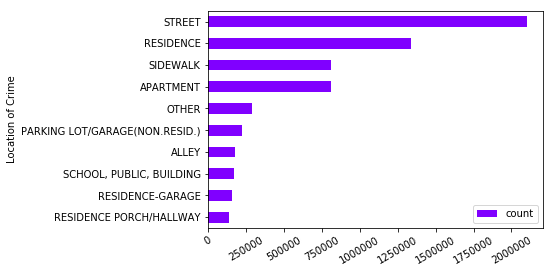

In [23]:
location_counts_sorted_df = location_all_counts_df.sort("count", ascending=False).limit(10)

pdf = location_counts_sorted_df.toPandas()
pdf = pdf.sort_values(by="count", ascending=True)
pdf.plot(kind='barh', x='Location Description', y='count', colormap='rainbow')
plt.ylabel('Location of Crime')
plt.xticks(rotation=30)
plt.show()

# Year Analysis

## Homicides Per Year
http://www.newsweek.com/2016/12/23/chicago-gangs-violence-murder-rate-532034.html

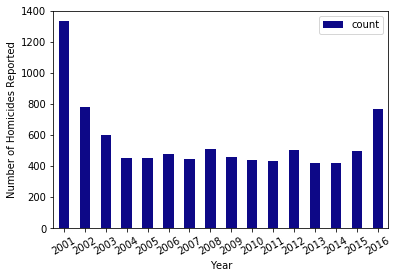

In [24]:
homicide_per_year_df = crime_df.filter(crime_df["Primary Type"] == 'HOMICIDE').groupBy("Year").count().sort(
    "Year", ascending=True)

pdf = homicide_per_year_df.toPandas()
pdf.plot(kind='bar', x='Year', y='count', colormap='plasma')
plt.ylabel('Number of Homicides Reported')
plt.xticks(rotation=30)
plt.show()

## Crimes Per Year
Shows number of crimes reported by year.

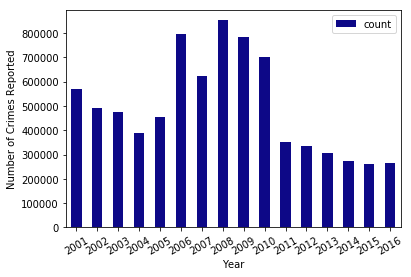

In [25]:
crime_per_year_df = crime_df.groupBy("Year").count().sort("Year")

pdf = crime_per_year_df.toPandas()
pdf.plot(kind='bar', x='Year', y='count', colormap='plasma')
plt.ylabel('Number of Crimes Reported')
plt.xticks(rotation=30)
plt.show()

# Arrests Per Year
Shows number of actual arrests made by year. Not every crime reported resulted in an arrest. Sorted by years with highest arrest number.

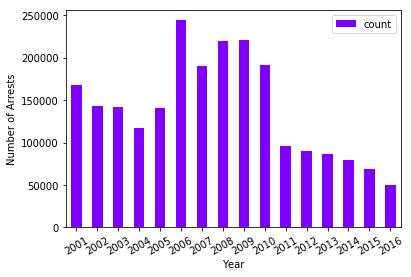

In [26]:
arrests_per_year_df = crime_df.where(crime_df.Arrest == "True").groupBy("Year").count().sort("Year")

pdf = arrests_per_year_df.toPandas()
pdf.plot(kind='bar', x='Year', y='count', colormap='rainbow')
plt.ylabel('Number of Arrests')
plt.xticks(rotation=30)
plt.show()


# Crime to Arrest Ratio
Calculate ratio of actual arrests from reported crime.
Create two separate data frames containing year and counts, one with all crimes (all rows) and second with rows that have Arrest => true.

In [27]:
# Collect Year and Count with crimes that had arrests
arrests_only_df = crime_df.where(crime_df.Arrest == "True")
arrests_only_df = arrests_only_df.groupBy("Year").agg(
    func.count(arrests_only_df.ID).alias("arrest_count")) 

# Collect Year and Count with all crimes
all_crime_df = crime_df.groupBy("Year").agg(
    func.count(crime_df.ID).alias("crime_count")) 

# Join arrests only and all crime stats counts into one "table"
joined_df = all_crime_df.join(arrests_only_df, "Year")

# Get ratio
print("*** Arrest Ratio per Year ***")
ratio_df = joined_df.select(joined_df.Year, (
    (joined_df.arrest_count / joined_df.crime_count) * 100).cast("integer").alias("arrest_ratio")
)
ratio_df.show()


*** Arrest Ratio per Year ***
+----+------------+
|Year|arrest_ratio|
+----+------------+
|2016|          18|
|2012|          26|
|2014|          28|
|2013|          28|
|2005|          30|
|2002|          29|
|2009|          28|
|2006|          30|
|2004|          30|
|2011|          27|
|2008|          25|
|2007|          30|
|2015|          26|
|2001|          29|
|2010|          27|
|2003|          29|
+----+------------+



info online discussing arrests precentages significantly down in recent years (2016, 2017)
https://chicago.suntimes.com/chicago-politics/the-watchdogs-arrests-down-25-percent-in-chicago-this-year/
https://www.google.com/search?q=chicago+arrests+down+in+2016&oq=chicago+arrests+down+in+2016&aqs=chrome..69i57.5702j0j4&sourceid=chrome&ie=UTF-8

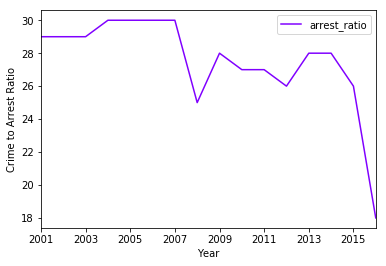

In [28]:
pdf = ratio_df.sort("Year").toPandas()
pdf.plot(kind='line', x='Year', y='arrest_ratio', colormap='rainbow')
plt.ylabel('Crime to Arrest Ratio')
plt.show()

# Top Crimes per Year

In [37]:
year_max_cnt_df = crime_df.groupBy("Year", "Primary Type").count().groupBy("Year").agg(
    func.max("count").alias("count"))
year_type_count_df = crime_df.groupBy("Year", "Primary Type").count()
year_type_count_df.join(year_max_cnt_df, ["count", "Year"]).sort("Year").show()

+------+----+------------+
| count|Year|Primary Type|
+------+----+------------+
|115887|2001|       THEFT|
| 99074|2002|       THEFT|
| 99069|2003|       THEFT|
| 81365|2004|       THEFT|
| 86400|2005|       THEFT|
|152292|2006|       THEFT|
|118863|2007|       THEFT|
|176635|2008|       THEFT|
|161815|2009|       THEFT|
|144397|2010|       THEFT|
| 75249|2011|       THEFT|
| 75454|2012|       THEFT|
| 71524|2013|       THEFT|
| 61530|2014|       THEFT|
| 57292|2015|       THEFT|
| 61167|2016|       THEFT|
+------+----+------------+



# Least Crimes per Year

In [38]:
year_max_cnt_df = crime_df.groupBy("Year", "Primary Type").count().groupBy("Year").agg(
    func.min("count").alias("count"))
year_type_count_df = crime_df.groupBy("Year", "Primary Type").count()
year_type_count_df.join(year_max_cnt_df, ["count", "Year"]).sort("Year").show()

+-----+----+-----------------+
|count|Year|     Primary Type|
+-----+----+-----------------+
|    2|2001|DOMESTIC VIOLENCE|
|    2|2002|        RITUALISM|
|    1|2003|     NON-CRIMINAL|
|    1|2003|        RITUALISM|
|    1|2004|        RITUALISM|
|    3|2005|        RITUALISM|
|    8|2006| PUBLIC INDECENCY|
|    1|2007|        RITUALISM|
|    8|2008| PUBLIC INDECENCY|
|    1|2009|     NON-CRIMINAL|
|    2|2010|     NON-CRIMINAL|
|   13|2011| PUBLIC INDECENCY|
|    8|2012|     NON-CRIMINAL|
|    2|2013|HUMAN TRAFFICKING|
|    2|2014|HUMAN TRAFFICKING|
|   13|2015|HUMAN TRAFFICKING|
|   10|2016| PUBLIC INDECENCY|
+-----+----+-----------------+



# Top 10 Crimes
Top 10 crimes, all years.
Collect count of each crime type per year, then take an average of counts to get top 10 crimes.

In [39]:
temp_df = crime_df.groupBy("Year", "Primary Type").count().groupBy("Primary Type").agg(
    func.avg("count").cast("integer").alias("Avg Count"))
temp_df.sort("Avg Count", ascending=False).limit(10).show()

+-------------------+---------+
|       Primary Type|Avg Count|
+-------------------+---------+
|              THEFT|   102375|
|            BATTERY|    90046|
|    CRIMINAL DAMAGE|    57605|
|          NARCOTICS|    55322|
|      OTHER OFFENSE|    30690|
|            ASSAULT|    30055|
|           BURGLARY|    29393|
|MOTOR VEHICLE THEFT|    23114|
|            ROBBERY|    18740|
| DECEPTIVE PRACTICE|    17517|
+-------------------+---------+



# Top 10 Crimes with Arrests
Top 10 crimes, all years that resulted in arrests.
Collect count of each crime type per year that had Arrests=True, then take an average of counts to get top 10 crimes.

In [40]:
temp_df = crime_df.where(crime_df.Arrest == "True").groupBy("Year", "Primary Type").count().groupBy("Primary Type").agg(
    func.avg("count").cast("integer").alias("Avg Count"))
temp_df.sort("Avg Count", ascending=False).limit(10).show()

+------------------+---------+
|      Primary Type|Avg Count|
+------------------+---------+
|         NARCOTICS|    54884|
|           BATTERY|    20605|
|             THEFT|    12263|
| CRIMINAL TRESPASS|    10496|
|           ASSAULT|     7113|
|      PROSTITUTION|     5370|
|     OTHER OFFENSE|     5204|
|   CRIMINAL DAMAGE|     4082|
| WEAPONS VIOLATION|     3869|
|DECEPTIVE PRACTICE|     3295|
+------------------+---------+



## Most Dangerous / Safest Hour

Calculates counts of crimes per date, then take an average of those counts to determine safest / most dangerous hour.


In [41]:
date_format = "MM/dd/yyyy hh:mm:ss a"

by_hour_df = crime_df.select(
    func.date_format(func.unix_timestamp(crime_df.Date, date_format
        ).cast("timestamp"), "MM/dd/yyyy").alias("JustDate"), 
    func.date_format(func.unix_timestamp(crime_df.Date, date_format
        ).cast("timestamp"), "HH").alias("JustHour")
    ).groupBy("JustDate", "JustHour").count().groupBy("JustHour").agg(
        func.avg("count").cast("integer").alias("AvgCount")).sort("AvgCount", ascending=False)
by_hour_df.show(24, False)

+--------+--------+
|JustHour|AvgCount|
+--------+--------+
|20      |77      |
|00      |77      |
|19      |77      |
|21      |76      |
|12      |76      |
|22      |75      |
|18      |73      |
|15      |71      |
|17      |68      |
|14      |68      |
|16      |67      |
|13      |64      |
|23      |62      |
|11      |59      |
|09      |57      |
|10      |56      |
|08      |45      |
|01      |43      |
|02      |36      |
|07      |30      |
|03      |29      |
|06      |21      |
|04      |21      |
|05      |17      |
+--------+--------+



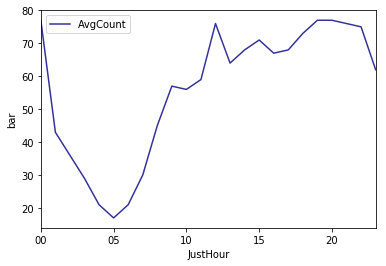

In [42]:
pdf = by_hour_df.sort("JustHour").toPandas()
pdf.plot(kind='line', x='JustHour', y='AvgCount', colormap='terrain')
plt.ylabel('bar')
plt.show()

## Time of Day to Crime Rates (Homicide, Burglary, Arson, Theft)

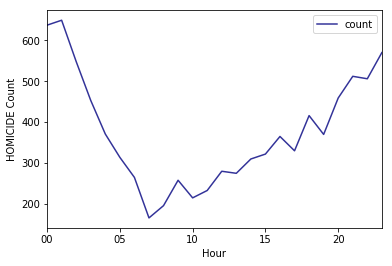

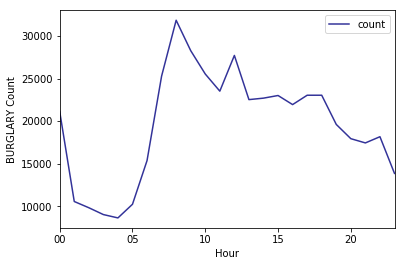

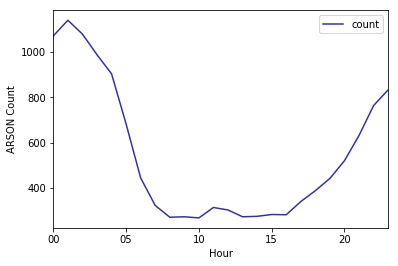

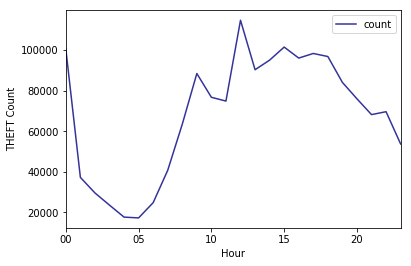

In [43]:
date_format = "MM/dd/yyyy hh:mm:ss a"

for pri_type in ("HOMICIDE", "BURGLARY", "ARSON", "THEFT"):
    hour_counts_df = crime_df.filter(crime_df["Primary Type"] == pri_type).select(
            func.date_format(func.unix_timestamp(crime_df.Date, date_format
        ).cast("timestamp"), "HH").alias("Hour")).groupBy("Hour").count()
    pdf = hour_counts_df.sort("Hour").toPandas()
    pdf.plot(kind='line', x='Hour', y='count', colormap='terrain')
    plt.ylabel('%s Count' % pri_type)
    plt.show()

# Crimes by Districts

<img src="http://chronicle.uchicago.edu/991104/map.gif">

In [44]:
by_district_df = crime_df.filter(crime_df["District"].isNotNull()).groupBy(crime_df["District"]).count()

print("*** Top 5 Low Crime Districts ***")
by_district_df.sort("count").select(crime_df["District"].cast("integer"), "count").limit(5).show()
print("*** Top 10 High Crime Districts ***")
by_district_df.sort("count", ascending=False).select(crime_df["District"].cast("integer"), "count").limit(10).show()



*** Top 5 Low Crime Districts ***
+--------+------+
|District| count|
+--------+------+
|      23|     1|
|      13|     1|
|      21|     4|
|      31|   158|
|      20|137134|
+--------+------+

*** Top 10 High Crime Districts ***
+--------+------+
|District| count|
+--------+------+
|       8|549264|
|      11|497996|
|       7|475970|
|      25|463221|
|       6|456926|
|       4|453322|
|       3|407374|
|       9|397429|
|      12|385644|
|       2|377806|
+--------+------+



In [45]:
homicide_by_district_df = crime_df.filter(crime_df["District"].isNotNull()).filter(
    crime_df["Primary Type"] == "HOMICIDE").groupBy(crime_df["District"]).count()
print("*** Top 5 Low Homicide Districts ***")
homicide_by_district_df.sort("count").select(crime_df["District"].cast("integer"), "count").limit(5).show()
print("*** Top 10 High Homicide Districts ***")
homicide_by_district_df.sort("count", ascending=False).select(crime_df["District"].cast("integer"), "count").limit(10).show()

*** Top 5 Low Homicide Districts ***
+--------+-----+
|District|count|
+--------+-----+
|      20|   72|
|      16|   75|
|       1|   96|
|      18|  110|
|      17|  140|
+--------+-----+

*** Top 10 High Homicide Districts ***
+--------+-----+
|District|count|
+--------+-----+
|      11|  892|
|       7|  826|
|       6|  667|
|      10|  633|
|       4|  612|
|       9|  604|
|       3|  573|
|       5|  551|
|       8|  548|
|      15|  516|
+--------+-----+

